In [1]:
import copy
import matplotlib.pyplot as plt
import numpy.random
from sklearn.linear_model import LinearRegression
import numpy as np
from typing import Callable
import torch
import torch.nn as nn
import torch.nn.functional as F
import MyNeuralNetwork_New


### PyTorch network class for comparison with our network

In [2]:
# pyTorch neural network class

class myPytorchNetwork(nn.Module):
    def __init__(self, layers, activation):
        super(myPytorchNetwork, self).__init__()
        self.activation = activation
        self.fc_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])

    def forward(self, x):
        x = torch.flatten(x, 1)

        # TODO: I'm using relus everywhere for now, we need to change it to be adjustable
        for layer in self.fc_layers[:-1]:
            if self.activation == 'linear':
                x = layer(x)
            elif self.activation == 'relu':
                x = F.relu(layer(x))
            elif self.activation == 'sigmoid':
                x = torch.sigmoid(layer(x))
            elif self.activation == 'tanh':
                x = torch.tanh(layer(x))
            else:
                raise ValueError(f"Activation funtion {self.activation} is invalid")


        # No need for activation in the last layer
        return self.fc_layers[-1](x)


def train_torch_network(network: myPytorchNetwork, dataset, max_epochs, batch_size, train_ratio=0.8,
                        learning_rate=0.001, momentum=0.9, silent=False):
    loss_fn = torch.nn.MSELoss()
    # TODO: think of making the learning rate adaptive here, e.g. by using pytorch LR scheduler
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    split_index = int(dataset.shape[0] * train_ratio)
    train, validation = dataset[:split_index, :], torch.from_numpy(dataset[split_index:, :])

    best_validation_loss = float("inf")

    for epoch in range(max_epochs):
        np.random.shuffle(train)
        torch_train = torch.from_numpy(train)
        batch_start_idx = 0

        batches_loss = []
        # This way we skip last samples if there are less than batch_size of them
        while batch_start_idx + batch_size <= torch_train.shape[0]:
            optimizer.zero_grad()
            outputs = network(torch_train[batch_start_idx:batch_start_idx + batch_size, :-1])
            loss = loss_fn(torch.flatten(outputs), torch_train[batch_start_idx:batch_start_idx + batch_size, -1])
            batches_loss.append(loss.item())

            loss.backward()

            optimizer.step()
            batch_start_idx += batch_size

        # Now, check the loss on validation dataset
        validation_output = torch.flatten(network(validation[:, :-1]))
        validation_loss = loss_fn(validation_output, validation[:, -1])

        best_validation_loss = validation_loss

        if not silent:
            print(
                f"Epoch: {epoch}. \nLoss on training: {np.mean(batches_loss)} \nLoss on validation: {validation_loss} \n##########")


### Helper functions to run each model multiple times and gathering statistics

In [3]:
def run_my_neural_network(network_parameters, train_dataset, test_inputs) -> np.array:
    """
    Train our neural network and predict data from test_inputs
    """
    network = MyNeuralNetwork_New.MyNeuralNetwork(*network_parameters)
    network.fit(train_dataset[:, :-1], train_dataset[:, [-1]], batch_size=10)
    prediction = network.predict(test_inputs)
    return prediction



def run_linear_regression(train_dataset, test_inputs) -> np.array:
    """
    Train a linear regression on train_inputs, and predict data for test_inputs
    """
    reg = LinearRegression().fit(train_dataset[:, :-1], train_dataset[:, -1])
    prediction = reg.predict(test_inputs)
    return prediction


def run_pytorch_network(network_parameters,  train_dataset, test_inputs) -> np.array:
    """
    Train a pytorch network and predict outputs for test_inputs
    """
    network = myPytorchNetwork(*network_parameters)
    train_torch_network(network, train_dataset, 1000, 10, learning_rate=0.005, silent=True, momentum=0.9, train_ratio=0.98)
    prediction = network(torch.from_numpy(test_inputs)).detach().numpy().flatten()
    return prediction


def measure_model_error_multiple_times(model: Callable, dataset: np.array, train_ratio=0.85, num_runs=5, silent=False):
    """
    :param model: a callable that accepts train dataset, test inputs, and produces the prediction for test inputs
    :param dataset: dataset to train on of shape (n_samples, n_features), where the last column is the value to be predicted
    :param train_ratio: how much data to put into the training dataset
    :param num_runs: number of runs with reshuffled dataset
    :param silent: if true, not print any output
    :return: mean MSE through all the runs
    """
    split_index = int(dataset.shape[0] * train_ratio)
    best_mape = 0
    best_mse = float("inf")
    for _ in range(num_runs):
        np.random.shuffle(dataset)
        train = dataset[:split_index, :]
        test = dataset[split_index:, :]

        prediction = model(train, test[:, :-1]).flatten()
        expected = test[:, -1].flatten()
        mse = np.mean((prediction - expected) ** 2)
        mape = 100 * np.mean(np.abs((prediction - expected) / expected))
        if not silent:
            print(f"Model MSE on test: {mse}")

        if mse < best_mse:
            best_mse = mse
            best_mape = mape

    return best_mape, best_mse

def calculate_mape(real, predicted):
    return 100 * np.mean(np.abs((predicted - real) / real))


In [4]:
# Load the data
turbine = np.genfromtxt("processed_datasets/turbine.csv", dtype=np.float32, delimiter=',', skip_header=1)
synthetic = np.genfromtxt("processed_datasets/synthetic.csv", dtype=np.float32, delimiter=',', skip_header=1)
boston = np.genfromtxt("processed_datasets/boston.csv", dtype=np.float32, delimiter=',', skip_header=1)
turbine_input, turbine_output = turbine[:, :4], turbine[:, 4]

#### Just trying multiple times with different parameters to make sure that everything works

In [ ]:
# Trying a couple of times with different splits into training and test data for a better understanging
measure_model_error_multiple_times(run_linear_regression, turbine)

Model MSE on test: 0.0010041567729786038
Model MSE on test: 0.0008605378679931164
Model MSE on test: 0.001181447645649314
Model MSE on test: 0.0011038235388696194
Model MSE on test: 0.0009636962204240263


(7.171326130628586, 0.00086053787)

In [ ]:
# Now trying, maybe applying some functions to features can make the situation better. There is no obvious relation here, but after trying, we found this gives better results (not always, but mostly better)

modified_turbine = turbine.copy()
modified_turbine[:, 1] = modified_turbine[:, 1] ** 2
modified_turbine[:, 0] = modified_turbine[:, 0] ** 2
measure_model_error_multiple_times(run_linear_regression, modified_turbine)

Model MSE on test: 0.0007500104838982224
Model MSE on test: 0.0008878853404894471
Model MSE on test: 0.0012019140413030982
Model MSE on test: 0.0008695840951986611
Model MSE on test: 0.001289607840590179


(6.411221623420715, 0.0007500105)

In [10]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[9, 5, 1], 'tanh'], *args), synthetic, num_runs=2)

Model MSE on test: 0.0008556755492463708
Model MSE on test: 0.0014447271823883057


(6.419110298156738, 0.00085567555)

In [11]:
measure_model_error_multiple_times(lambda *args: run_my_neural_network([[9, 5, 1], 50, 0.01, 0.9, "tanh", 0.2], *args), synthetic, num_runs=5)

Model MSE on test: 0.0009287080225645291
Model MSE on test: 0.0012616572249815941
Model MSE on test: 0.0022008422923728266
Model MSE on test: 0.001308189292498391
Model MSE on test: 0.0014083867343092627


(7.2931592000044105, 0.0009287080225645291)

## Part 3.1

In [29]:
import random
# network_architectures =[
# # relativly small network, with large middle layer
# [5, 20,1],
# # a deeper network with incresing number of neurons
# [5, 10, 15, 20, 1],
# # a network with decreasing layers sizes
# [6, 18, 12, 8, 4, 2, 1],
# # a network which expands and than contradicts
# [5, 10, 20, 10, 5, 1],
# # a network with small layers
# [5, 8, 8, 8, 8, 8, 1],
# # a network with a bottleneck
# [5, 20, 5, 20, 10, 1],
# # a network which alternates layers sizes
# [5, 24, 12, 24, 12, 1],
# # exponential increase of layers
# [4, 8, 16, 32, 64, 1]
# ]


network_architectures =[
# relativly small network, with large middle layer
[5, 20,1],
[5,8,1],
[4,16,8,1],
[4,3,3,3,1],
[4,5,8,4,1]
]


learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
momentum = [0.0, 0.1, 0.2, 0.4,0.6,0.7, 0.8, 0.9]

activation_functions = ['tanh','linear','sigmoid','relu','lrelu']


def create_params(activation_functions, network_architectures, learning_rate, momentum):

    n_activation = len(activation_functions)
    return_test_params = []
    for activation_fuc in activation_functions:
        random.shuffle(learning_rate)
        random.shuffle(momentum)
        for i in range(len(network_architectures)):
            param = []
            param.append(len(network_architectures[i]))
            param.append(network_architectures[i])
            lr = learning_rate[i%len(learning_rate)]
            if(activation_fuc in ['linear','relu','lrelu']):
                lr = 0.001
            param.append(lr)
            param.append(momentum[i%len(momentum)])
            param.append(activation_fuc)
            return_test_params.append(param)

    return return_test_params

test_params = create_params(activation_functions, network_architectures,learning_rate, momentum )

In [30]:
import pandas as pd
pd.DataFrame(test_params)

0                1      2    3        4
0   3       [5, 20, 1]  0.100  0.0     tanh
1   3        [5, 8, 1]  0.050  0.7     tanh
2   4    [4, 16, 8, 1]  0.010  0.4     tanh
3   5  [4, 3, 3, 3, 1]  0.200  0.8     tanh
4   5  [4, 5, 8, 4, 1]  0.150  0.2     tanh
5   3       [5, 20, 1]  0.001  0.9   linear
6   3        [5, 8, 1]  0.001  0.2   linear
7   4    [4, 16, 8, 1]  0.001  0.6   linear
8   5  [4, 3, 3, 3, 1]  0.001  0.8   linear
9   5  [4, 5, 8, 4, 1]  0.001  0.4   linear
10  3       [5, 20, 1]  0.010  0.6  sigmoid
11  3        [5, 8, 1]  0.200  0.7  sigmoid
12  4    [4, 16, 8, 1]  0.100  0.8  sigmoid
13  5  [4, 3, 3, 3, 1]  0.050  0.9  sigmoid
14  5  [4, 5, 8, 4, 1]  0.150  0.1  sigmoid
15  3       [5, 20, 1]  0.001  0.4     relu
16  3        [5, 8, 1]  0.001  0.0     relu
17  4    [4, 16, 8, 1]  0.001  0.9     relu
18  5  [4, 3, 3, 3, 1]  0.001  0.1     relu
19  5  [4, 5, 8, 4, 1]  0.001  0.8     relu
20  3       [5, 20, 1]  0.001  0.8    lrelu
21  3        [5, 8, 1]  0.001  0.0    lrelu
22  4    [4, 16, 8, 1]  0.001  0.2    lrelu
23  5  [4, 3, 3, 3, 1]  0.001  0.1    lrelu
24  5  [4, 5, 8, 4, 1]  0.001  0.4    lrelu

In [31]:

def execute_parameters(test_parameters, dataset, epochs, num_of_runs=10):

    for parameters in test_parameters:
        n_layers, layers, lr, momentum, activation = parameters
        # getting number of features of features for first neuron row
        layers[0] = len(eval(dataset)[0])-1
        
        mape, mse = measure_model_error_multiple_times(lambda *args: run_my_neural_network([layers, epochs, lr, momentum, activation, 0.2], *args), eval(dataset), num_runs=num_of_runs, silent=True)
        #print(" & ".join(map(str, parameters)) + " & {:.1f} & {:.3f} \\\\\n\\hline".format(mape, mse))
        print(f'epochs:{epochs}, number_of_layer:{n_layers}, archi: {layers}, lr. {lr}, momentum.{momentum}, activation:{activation}, MAPE: {mape:.1f}%, MSE :{mse:.3f}')
        #run_and_plot_for_dataset([layers, epochs, lr, momentum, activation, 0.2], eval(dataset), 0.85, dataset)



In [34]:
import warnings
warnings.filterwarnings('ignore')
execute_parameters(test_params, 'turbine' , 500, 5)

epochs:500, number_of_layer:3, archi: [4, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 2.1%, MSE :0.000
epochs:500, number_of_layer:3, archi: [4, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 1.8%, MSE :0.000
epochs:500, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 1.8%, MSE :0.000
epochs:500, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 188.2%, MSE :0.347
epochs:500, number_of_layer:5, archi: [4, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 1.5%, MSE :0.000
epochs:500, number_of_layer:3, archi: [4, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 7.8%, MSE :0.001
epochs:500, number_of_layer:3, archi: [4, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 8.6%, MSE :0.001
epochs:500, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:500, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr. 0.001, m

In [37]:
execute_parameters(test_params, 'turbine' , 1000, 5)

epochs:1000, number_of_layer:3, archi: [4, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 1.7%, MSE :0.000
epochs:1000, number_of_layer:3, archi: [4, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 1.4%, MSE :0.000
epochs:1000, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 1.6%, MSE :0.000
epochs:1000, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 191.2%, MSE :0.338
epochs:1000, number_of_layer:5, archi: [4, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 1.9%, MSE :0.000
epochs:1000, number_of_layer:3, archi: [4, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 9.5%, MSE :0.001
epochs:1000, number_of_layer:3, archi: [4, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 9.2%, MSE :0.001
epochs:1000, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 8.3%, MSE :0.001
epochs:1000, number_of_layer:5, archi: [4, 3, 3, 3, 1], l

In [38]:
execute_parameters(test_params, 'turbine' , 1500, 5)

epochs:1500, number_of_layer:3, archi: [4, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 1.4%, MSE :0.000
epochs:1500, number_of_layer:3, archi: [4, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 1.3%, MSE :0.000
epochs:1500, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 1.7%, MSE :0.000
epochs:1500, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 8.4%, MSE :0.001
epochs:1500, number_of_layer:5, archi: [4, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 1.2%, MSE :0.000
epochs:1500, number_of_layer:3, archi: [4, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 6.9%, MSE :0.001
epochs:1500, number_of_layer:3, archi: [4, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 9.1%, MSE :0.001
epochs:1500, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 8.5%, MSE :0.001
epochs:1500, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr.

In [41]:
execute_parameters(test_params, 'turbine' , 2000, 5)

epochs:2000, number_of_layer:3, archi: [4, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 1.7%, MSE :0.000
epochs:2000, number_of_layer:3, archi: [4, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 1.1%, MSE :0.000
epochs:2000, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 1.0%, MSE :0.000
epochs:2000, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 1.9%, MSE :0.000
epochs:2000, number_of_layer:5, archi: [4, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 1.1%, MSE :0.000
epochs:2000, number_of_layer:3, archi: [4, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 9.0%, MSE :0.001
epochs:2000, number_of_layer:3, archi: [4, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 8.5%, MSE :0.001
epochs:2000, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:2000, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr. 0

In [42]:
execute_parameters(test_params, 'turbine' , 2500, 5)

epochs:2500, number_of_layer:3, archi: [4, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 1.4%, MSE :0.000
epochs:2500, number_of_layer:3, archi: [4, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 1.5%, MSE :0.000
epochs:2500, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 1.4%, MSE :0.000
epochs:2500, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 2.4%, MSE :0.000
epochs:2500, number_of_layer:5, archi: [4, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 1.7%, MSE :0.000
epochs:2500, number_of_layer:3, archi: [4, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 8.7%, MSE :0.001
epochs:2500, number_of_layer:3, archi: [4, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 10.9%, MSE :0.001
epochs:2500, number_of_layer:4, archi: [4, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 7.3%, MSE :0.001
epochs:2500, number_of_layer:5, archi: [4, 3, 3, 3, 1], lr

In [35]:
execute_parameters(test_params, 'synthetic' , 500, 5)

epochs:500, number_of_layer:3, archi: [9, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 7.2%, MSE :0.001
epochs:500, number_of_layer:3, archi: [9, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 6.7%, MSE :0.001
epochs:500, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 6.7%, MSE :0.001
epochs:500, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 162.1%, MSE :0.334
epochs:500, number_of_layer:5, archi: [9, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 6.0%, MSE :0.001
epochs:500, number_of_layer:3, archi: [9, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 6.5%, MSE :0.001
epochs:500, number_of_layer:3, archi: [9, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 6.3%, MSE :0.001
epochs:500, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 6.9%, MSE :0.001
epochs:500, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0.001,

In [43]:
execute_parameters(test_params, 'synthetic' , 1000, 5)

epochs:1000, number_of_layer:3, archi: [9, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 7.1%, MSE :0.001
epochs:1000, number_of_layer:3, archi: [9, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 5.8%, MSE :0.001
epochs:1000, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 6.1%, MSE :0.001
epochs:1000, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 16.8%, MSE :0.004
epochs:1000, number_of_layer:5, archi: [9, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 6.5%, MSE :0.001
epochs:1000, number_of_layer:3, archi: [9, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 6.8%, MSE :0.001
epochs:1000, number_of_layer:3, archi: [9, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 6.4%, MSE :0.001
epochs:1000, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 6.9%, MSE :0.001
epochs:1000, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr

In [44]:
execute_parameters(test_params, 'synthetic' , 1500, 5)

epochs:1500, number_of_layer:3, archi: [9, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 5.7%, MSE :0.001
epochs:1500, number_of_layer:3, archi: [9, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 6.7%, MSE :0.001
epochs:1500, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 6.2%, MSE :0.001
epochs:1500, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 7.4%, MSE :0.001
epochs:1500, number_of_layer:5, archi: [9, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 7.5%, MSE :0.001
epochs:1500, number_of_layer:3, archi: [9, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 5.9%, MSE :0.001
epochs:1500, number_of_layer:3, archi: [9, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 6.1%, MSE :0.001
epochs:1500, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:1500, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0

In [45]:
execute_parameters(test_params, 'synthetic' , 2000, 5)

epochs:2000, number_of_layer:3, archi: [9, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 6.6%, MSE :0.001
epochs:2000, number_of_layer:3, archi: [9, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 6.1%, MSE :0.001
epochs:2000, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 5.5%, MSE :0.001
epochs:2000, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 8.0%, MSE :0.001
epochs:2000, number_of_layer:5, archi: [9, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 6.9%, MSE :0.001
epochs:2000, number_of_layer:3, archi: [9, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 7.4%, MSE :0.001
epochs:2000, number_of_layer:3, archi: [9, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 5.8%, MSE :0.001
epochs:2000, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:2000, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0

In [46]:
execute_parameters(test_params, 'synthetic' , 2500, 5)

epochs:2500, number_of_layer:3, archi: [9, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 6.6%, MSE :0.001
epochs:2500, number_of_layer:3, archi: [9, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 6.3%, MSE :0.001
epochs:2500, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 6.6%, MSE :0.001
epochs:2500, number_of_layer:5, archi: [9, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 158.9%, MSE :0.326
epochs:2500, number_of_layer:5, archi: [9, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 6.6%, MSE :0.001
epochs:2500, number_of_layer:3, archi: [9, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 7.1%, MSE :0.001
epochs:2500, number_of_layer:3, archi: [9, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 5.2%, MSE :0.001
epochs:2500, number_of_layer:4, archi: [9, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 5.3%, MSE :0.001
epochs:2500, number_of_layer:5, archi: [9, 3, 3, 3, 1], l

In [36]:
execute_parameters(test_params, 'boston' , 500, 5)

epochs:500, number_of_layer:3, archi: [13, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 14.7%, MSE :0.004
epochs:500, number_of_layer:3, archi: [13, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 14.4%, MSE :0.004
epochs:500, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 13.3%, MSE :0.004
epochs:500, number_of_layer:5, archi: [13, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 156.2%, MSE :0.335
epochs:500, number_of_layer:5, archi: [13, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 11.9%, MSE :0.003
epochs:500, number_of_layer:3, archi: [13, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 15.6%, MSE :0.005
epochs:500, number_of_layer:3, archi: [13, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 17.7%, MSE :0.005
epochs:500, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:500, number_of_layer:5, archi: [13, 3, 3, 3, 1

In [39]:
execute_parameters(test_params, 'boston' , 1000, 5)

epochs:1000, number_of_layer:3, archi: [13, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 13.7%, MSE :0.005
epochs:1000, number_of_layer:3, archi: [13, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 12.4%, MSE :0.003
epochs:1000, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 12.9%, MSE :0.003
epochs:1000, number_of_layer:5, archi: [13, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 177.9%, MSE :0.355
epochs:1000, number_of_layer:5, archi: [13, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 10.5%, MSE :0.003
epochs:1000, number_of_layer:3, archi: [13, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 16.9%, MSE :0.005
epochs:1000, number_of_layer:3, archi: [13, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 15.9%, MSE :0.005
epochs:1000, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:1000, number_of_layer:5, archi: [13, 3

In [40]:
execute_parameters(test_params, 'boston' , 1500, 5)

epochs:1500, number_of_layer:3, archi: [13, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 11.2%, MSE :0.003
epochs:1500, number_of_layer:3, archi: [13, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 14.3%, MSE :0.005
epochs:1500, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 9.1%, MSE :0.002
epochs:1500, number_of_layer:5, archi: [13, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 164.6%, MSE :0.333
epochs:1500, number_of_layer:5, archi: [13, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 9.9%, MSE :0.003
epochs:1500, number_of_layer:3, archi: [13, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 16.7%, MSE :0.007
epochs:1500, number_of_layer:3, archi: [13, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 20.9%, MSE :0.007
epochs:1500, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:1500, number_of_layer:5, archi: [13, 3, 

In [47]:
execute_parameters(test_params, 'boston' , 2000, 5)

epochs:2000, number_of_layer:3, archi: [13, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 15.1%, MSE :0.005
epochs:2000, number_of_layer:3, archi: [13, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 12.6%, MSE :0.003
epochs:2000, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 9.0%, MSE :0.004
epochs:2000, number_of_layer:5, archi: [13, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 161.0%, MSE :0.345
epochs:2000, number_of_layer:5, archi: [13, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 12.2%, MSE :0.002
epochs:2000, number_of_layer:3, archi: [13, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 15.4%, MSE :0.006
epochs:2000, number_of_layer:3, archi: [13, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 16.7%, MSE :0.005
epochs:2000, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 19.3%, MSE :0.009
epochs:2000, number_of_layer:5, archi: [13,

In [48]:
execute_parameters(test_params, 'boston' , 2500, 5)

epochs:2500, number_of_layer:3, archi: [13, 20, 1], lr. 0.1, momentum.0.0, activation:tanh, MAPE: 13.4%, MSE :0.004
epochs:2500, number_of_layer:3, archi: [13, 8, 1], lr. 0.05, momentum.0.7, activation:tanh, MAPE: 9.9%, MSE :0.002
epochs:2500, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.01, momentum.0.4, activation:tanh, MAPE: 12.5%, MSE :0.003
epochs:2500, number_of_layer:5, archi: [13, 3, 3, 3, 1], lr. 0.2, momentum.0.8, activation:tanh, MAPE: 168.5%, MSE :0.351
epochs:2500, number_of_layer:5, archi: [13, 5, 8, 4, 1], lr. 0.15, momentum.0.2, activation:tanh, MAPE: 10.7%, MSE :0.003
epochs:2500, number_of_layer:3, archi: [13, 20, 1], lr. 0.001, momentum.0.9, activation:linear, MAPE: 15.4%, MSE :0.007
epochs:2500, number_of_layer:3, archi: [13, 8, 1], lr. 0.001, momentum.0.2, activation:linear, MAPE: 18.5%, MSE :0.006
epochs:2500, number_of_layer:4, archi: [13, 16, 8, 1], lr. 0.001, momentum.0.6, activation:linear, MAPE: 0.0%, MSE :inf
epochs:2500, number_of_layer:5, archi: [13, 3,

In [85]:
np.random.seed(10)


# def execute_parameters(parameters, activation_function=None):
#     for parameters in test_parameters:
#         if activation_function != None:
#             parameters[6] = activation_function
#             print('hi')
#         dataset, n_layers, layers, epochs, lr, momentum, activation = parameters
        
#         lr = 0.0001
#         mape, mse = measure_model_error_multiple_times(lambda *args: run_my_neural_network([layers, epochs, lr, momentum, activation, 0.2], *args), eval(dataset), num_runs=8, silent=True)
#         print(" & ".join(map(str, parameters)) + " & {:.1f} & {:.3f} \\\\\n\\hline".format(mape, mse))
#         run_and_plot_for_dataset([layers, epochs, lr, momentum, activation, 0.2], eval(dataset), 0.85, dataset)







# test_parameters = [
#     ["turbine", 3, [4, 5, 1], 600, 0.01, 0.8, "relu"],
#     ["turbine", 3, [4, 5, 1], 600, 0.01, 0.8, "sigmoid"],
#     # ["turbine", 3, [4, 5, 1], 600, 0.01, 0.8, "tanh"],
#     # ["turbine", 3, [4, 5, 1], 600, 0.01, 0.8, "linear"],
#     # ["turbine", 6, [4, 5, 8, 600, 6, 1], 60, 0.001, 0.8, "tanh"],
#     # ["turbine", 2, [4, 1], 600, 0.01, 0.2, "relu"],
#     # ["turbine", 2, [4, 1], 600, 0.01, 0.7, "tanh"],
#     # ["turbine", 4, [4, 5, 8, 1], 600, 0.01, 0.2, "tanh"],
#     # ["turbine", 4, [4, 5, 8, 1], 600, 0.01, 0.2, "relu"],
#     ["synthetic", 4, [9, 8, 6, 1], 600, 0.01, 0.2, "relu"],
#     ["synthetic", 2, [9, 1], 600, 0.01, 0.9, "relu"],
#     # ["synthetic", 4, [9, 8, 6, 1], 600, 0.001, 0.2, "relu"],
#     # ["synthetic", 4, [9, 18, 16, 1], 600, 0.01, 0.2, "relu"],
#     # ["synthetic", 4, [9, 8, 6, 1], 600, 0.15, 0.8, "relu"],
#     # ["synthetic", 4, [9, 8, 6, 1], 600, 0.01, 0.8, "sigmoid"],
#     # ["synthetic", 4, [9, 8, 6, 1], 600, 0.01, 0.8, "tanh"],
#     # ["synthetic", 2, [9, 1], 600, 0.01, 0.9, "tanh"],
#     # ["synthetic", 6, [9, 8, 6, 5, 5, 1], 600, 0.01, 0.6, "tanh"],
#     # ["synthetic", 4, [9, 8, 6, 1], 600, 0.01, 0.2, "linear"],
#     ["boston", 4, [13, 8, 6, 1], 600, 0.001, 0.4, "relu"],
#     ["boston", 4, [13, 8, 6, 1], 600, 0.01, 0.8, "linear"],
#     # ["boston", 4, [13, 8, 6, 1], 600, 0.001, 0.7, "relu"],
#     # ["boston", 4, [13, 8, 6, 1], 600, 0.001, 0.2, "sigmoid"],
#     # ["boston", 4, [13, 18, 16, 1], 600, 0.01, 0.2, "tanh"],
#     # ["boston", 4, [13, 8, 6, 1], 600, 0.001, 0.2, "tanh"],
#     # ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 600, 0.01, 0.2, "tanh"],
#     # ["boston", 7, [13, 12, 12, 13, 10, 9, 1], 600, 0.001, 0.2, "tanh"],
#     # ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 600, 0.001, 0.2, "tanh"],
#     # ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 600, 0.001, 0, "tanh"],
# ]

#execute_parameters(test_parameters)

# The generated output here can be just copied directly to LaTeX tabl





In [7]:
# execution with only sigmoid
execute_parameters(test_parameters)

NEW
NEW
epoch . 0
length of random indices is 306
filed [[0.23020275 1.57136836 1.3020564  0.86642075 1.37919692 1.43958227
  1.08242125 0.3335982  0.62108845 1.44535743]
 [0.21589735 1.31228072 1.4820992  0.7266558  0.92969317 1.00453952
  1.06634576 0.05679217 0.19711161 1.08396895]
 [0.30558757 1.97641329 1.97436029 1.08570604 1.54307063 1.64052111
  1.49608438 0.22497081 0.50364699 1.71138983]
 [0.13797739 0.91346352 0.94377615 0.49366449 0.69280369 0.74062273
  0.69949584 0.07966004 0.20328437 0.77926677]
 [0.22650887 1.41277722 1.35564824 0.78346313 1.13651473 1.20196219
  1.05111318 0.20517584 0.41588756 1.24235228]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]] * ([[0.29821283]
 [1.80232286]
 [2.32039088]
 [1.00927008]
 [1.22618152]
 [1.32971813]
 [1.57073445]
 [0.00835478]
 [0.20550055]
 [1.44765094]] - [[0.02183359 0.61470923 0.28460908 0.6178703  0.3977774 ]])
activations
[array([[0.12820514

KeyboardInterrupt: 

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & relu & 7.4 & 0.001 \\
\hline
NEW
NEW


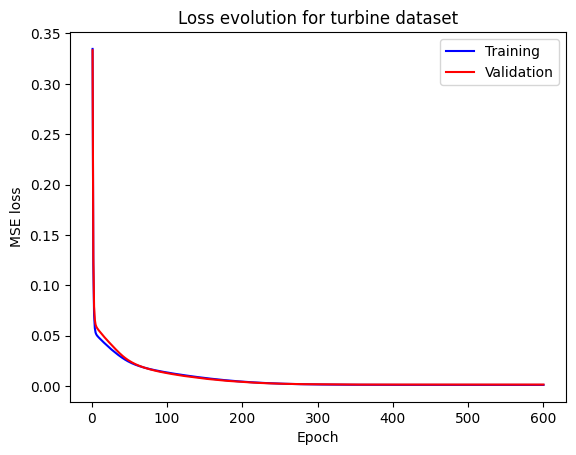

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & sigmoid & 8.2 & 0.001 \\
\hline
NEW
NEW


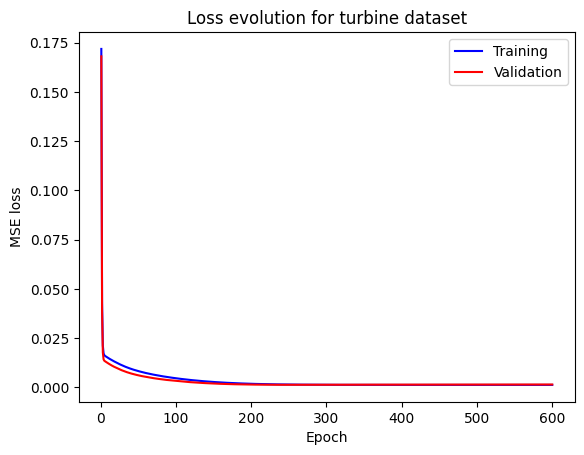

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & tanh & 7.2 & 0.001 \\
\hline
NEW
NEW


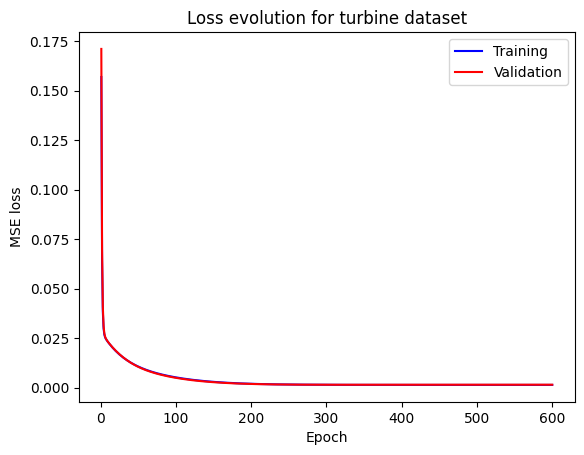

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & linear & 9.9 & 0.001 \\
\hline
NEW
NEW


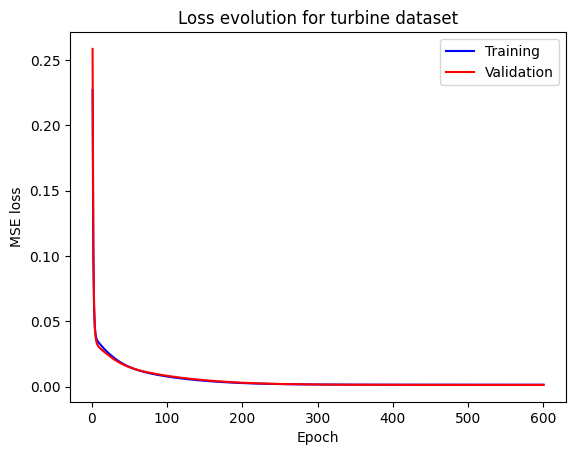

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 6 & [4, 5, 8, 600, 6, 1] & 60 & 0.001 & 0.8 & tanh & 100.0 & 0.192 \\
\hline
NEW
NEW
NEW
NEW
NEW


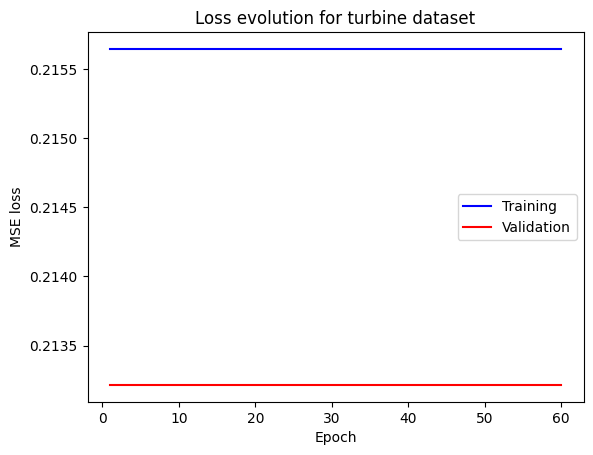

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 2 & [4, 1] & 600 & 0.01 & 0.2 & relu & 8.1 & 0.001 \\
\hline
NEW


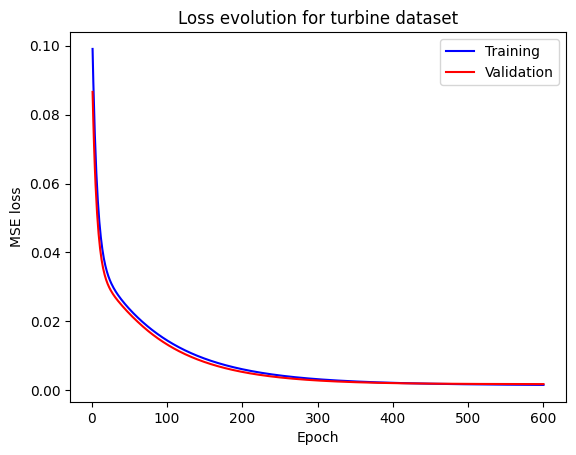

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 2 & [4, 1] & 600 & 0.01 & 0.7 & tanh & 8.7 & 0.001 \\
\hline
NEW


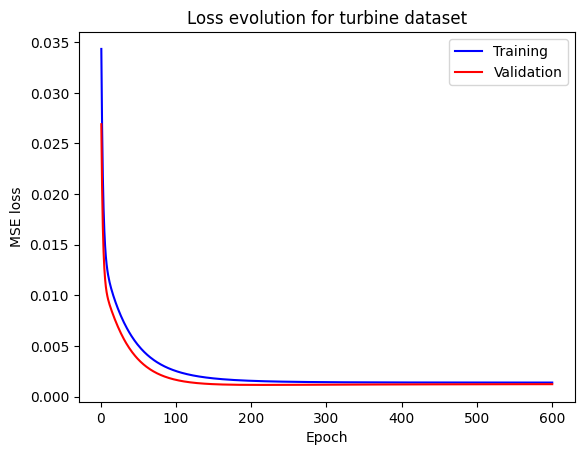

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 4 & [4, 5, 8, 1] & 600 & 0.01 & 0.2 & tanh & 10.0 & 0.001 \\
\hline
NEW
NEW
NEW


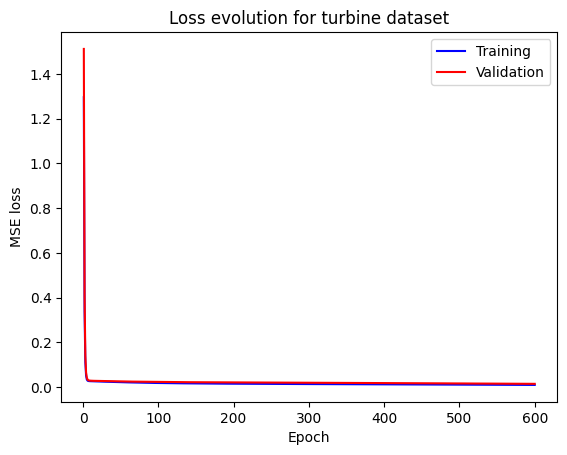

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 4 & [4, 5, 8, 1] & 600 & 0.01 & 0.2 & relu & 12.1 & 0.002 \\
\hline
NEW
NEW
NEW


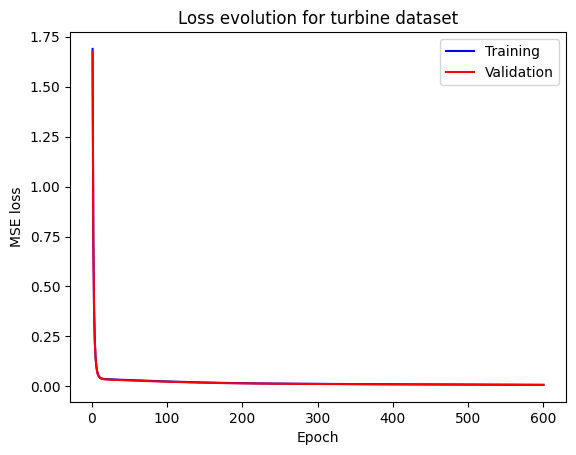

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.2 & relu & 10.5 & 0.003 \\
\hline
NEW
NEW
NEW


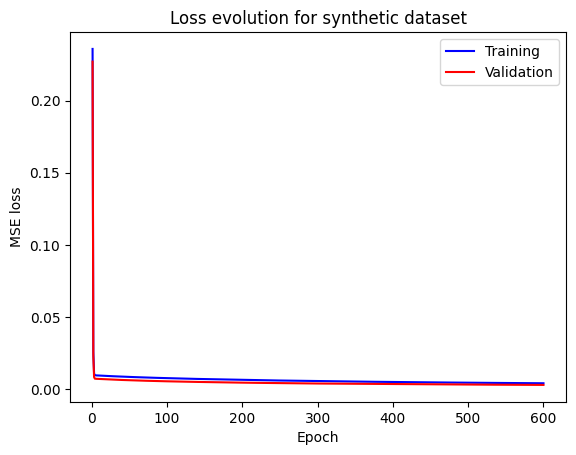

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 2 & [9, 1] & 600 & 0.01 & 0.9 & relu & 6.0 & 0.001 \\
\hline
NEW


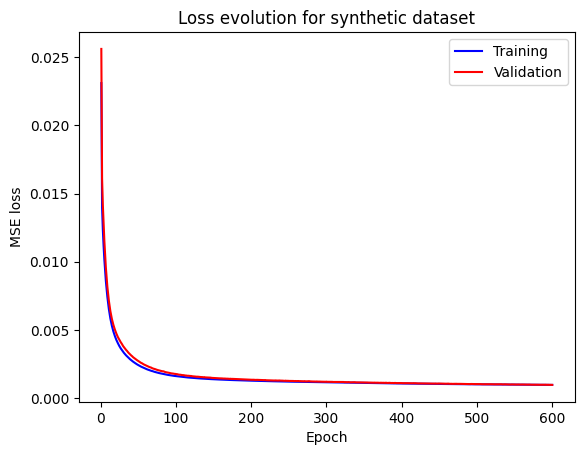

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.001 & 0.2 & relu & 11.6 & 0.003 \\
\hline
NEW
NEW
NEW


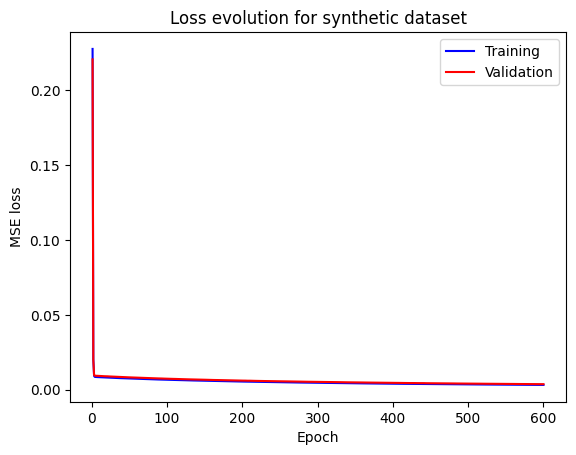

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 18, 16, 1] & 600 & 0.01 & 0.2 & relu & 10.5 & 0.003 \\
\hline
NEW
NEW
NEW


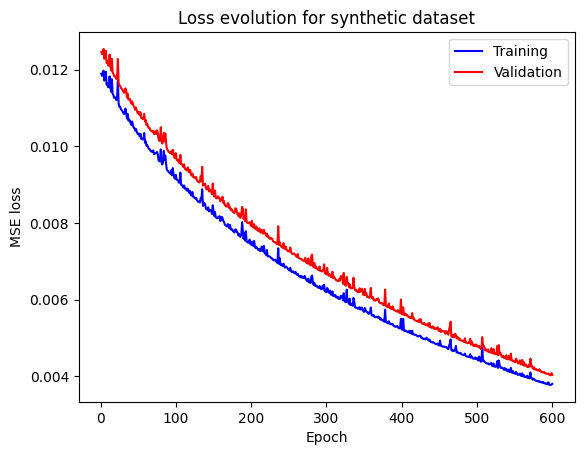

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.15 & 0.8 & relu & 8.0 & 0.001 \\
\hline
NEW
NEW
NEW


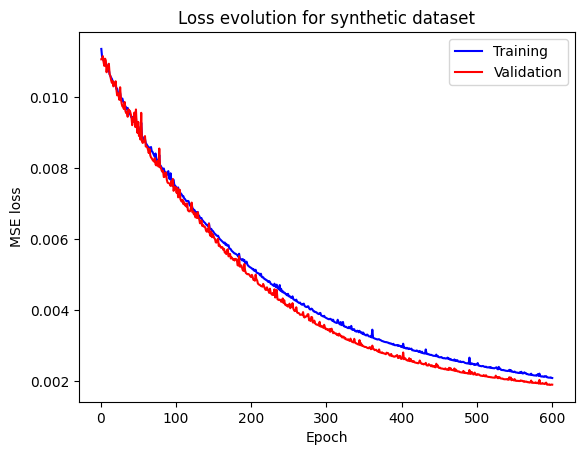

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.8 & sigmoid & 8.0 & 0.001 \\
\hline
NEW
NEW
NEW


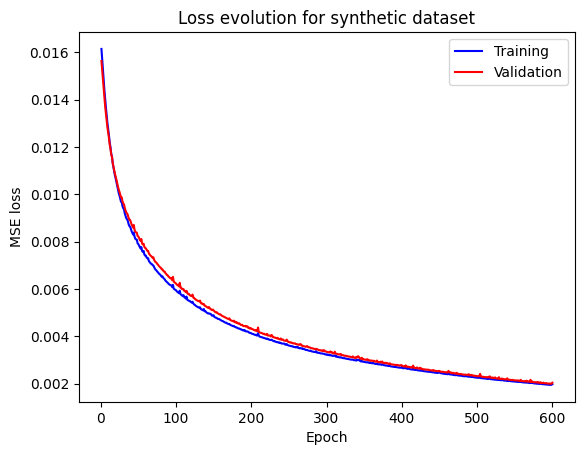

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.8 & tanh & 7.4 & 0.001 \\
\hline
NEW
NEW
NEW


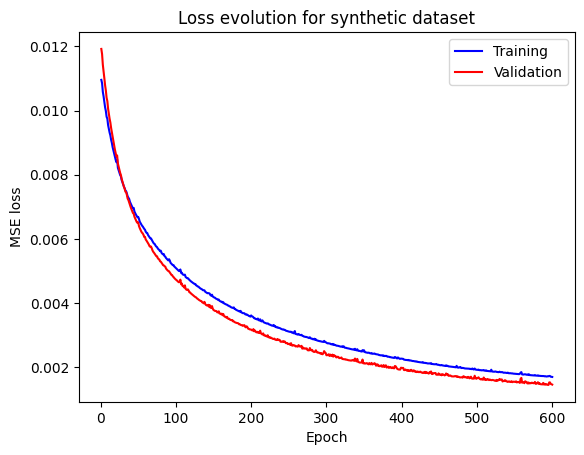

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 2 & [9, 1] & 600 & 0.01 & 0.9 & tanh & 6.1 & 0.001 \\
\hline
NEW


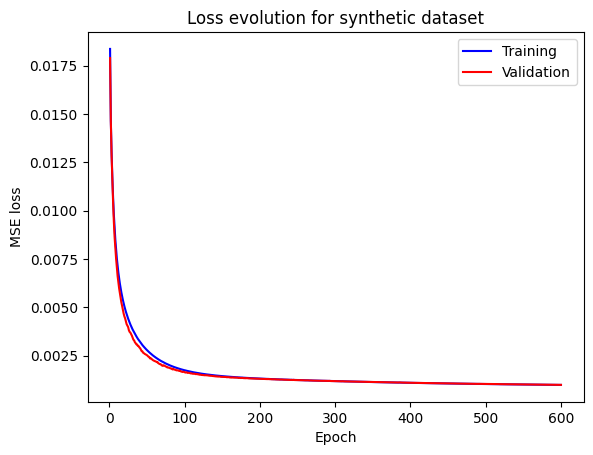

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 6 & [9, 8, 6, 5, 5, 1] & 600 & 0.01 & 0.6 & tanh & 11.1 & 0.003 \\
\hline
NEW
NEW
NEW
NEW
NEW


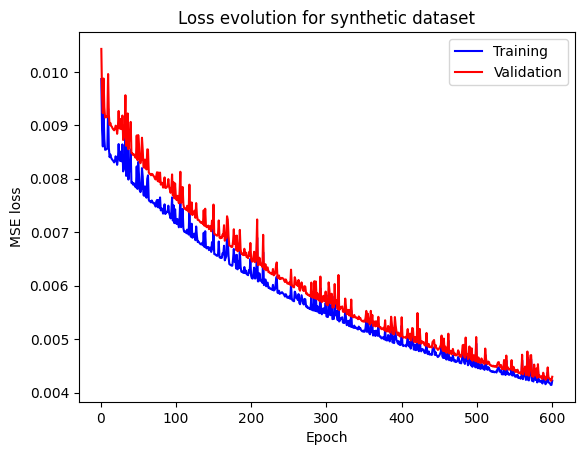

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.2 & linear & 9.1 & 0.002 \\
\hline
NEW
NEW
NEW


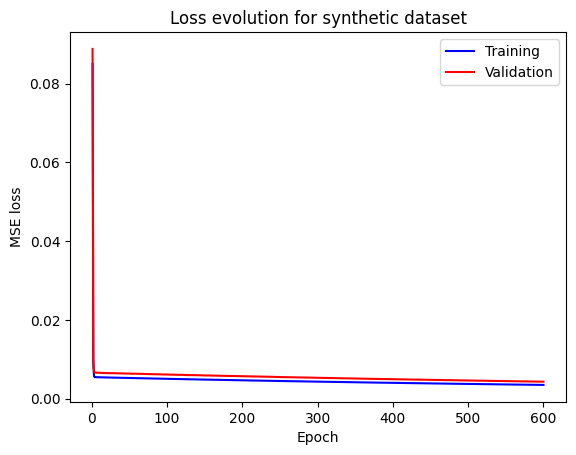

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
boston & 4 & [13, 8, 6, 1] & 600 & 0.001 & 0.4 & relu & 18.7 & 0.010 \\
\hline
NEW
NEW
NEW


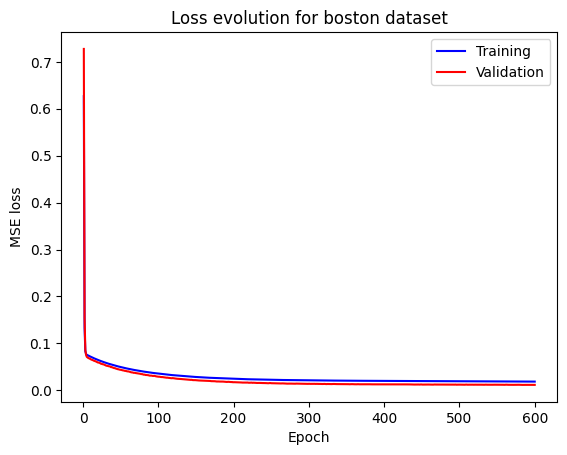

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
boston & 4 & [13, 8, 6, 1] & 600 & 0.01 & 0.8 & linear & 17.5 & 0.006 \\
\hline
NEW
NEW
NEW


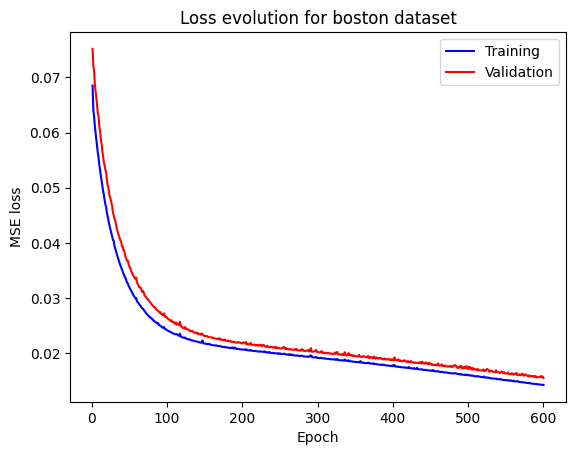

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW


KeyboardInterrupt: 

In [10]:
# execution with only relu
execute_parameters(test_parameters)

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & relu & 2.6 & 0.000 \\
\hline
NEW
NEW


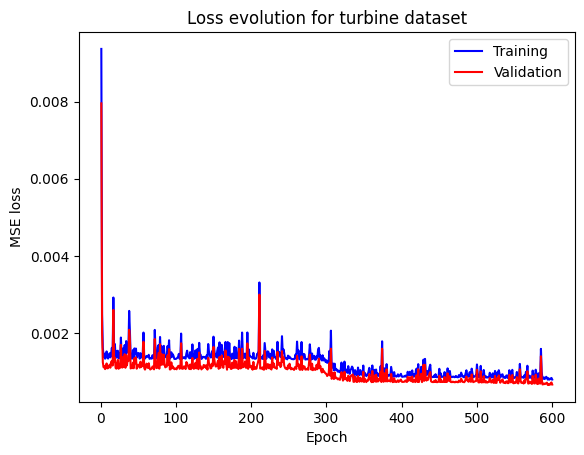

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & sigmoid & 3.1 & 0.000 \\
\hline
NEW
NEW


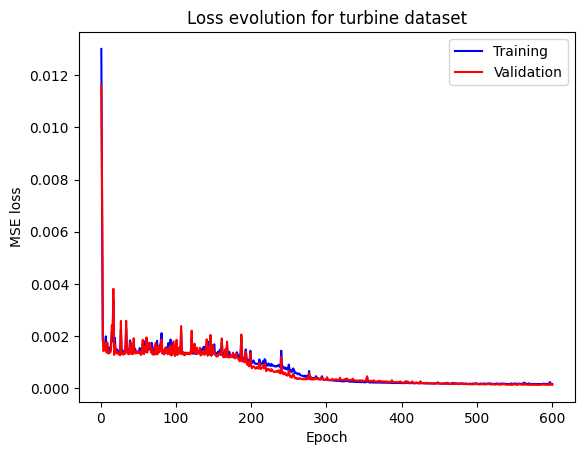

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.2 & relu & 100.0 & 0.215 \\
\hline
NEW
NEW
NEW


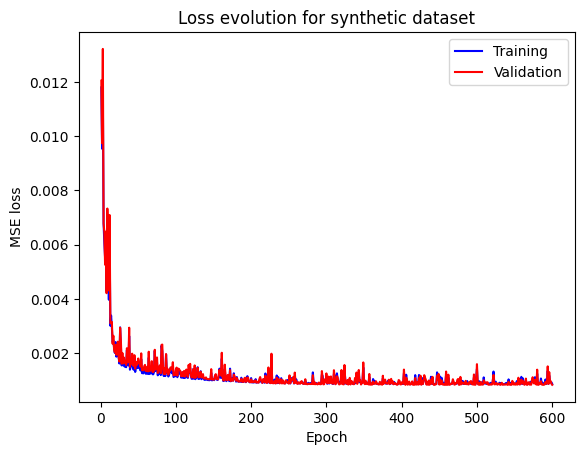

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 2 & [9, 1] & 600 & 0.01 & 0.9 & relu & 6.8 & 0.001 \\
\hline
NEW


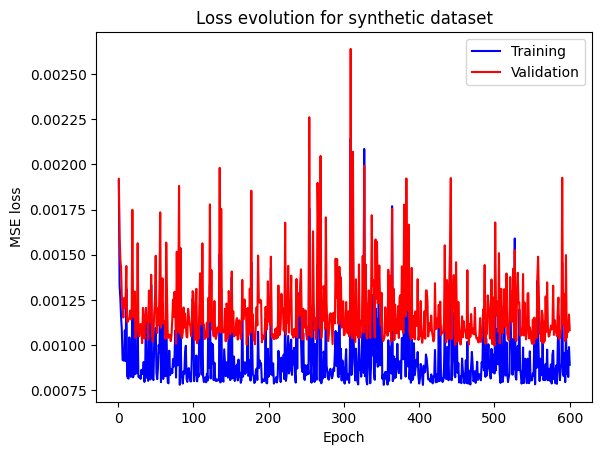

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
boston & 4 & [13, 8, 6, 1] & 600 & 0.001 & 0.4 & relu & 17.5 & 0.004 \\
\hline
NEW
NEW
NEW


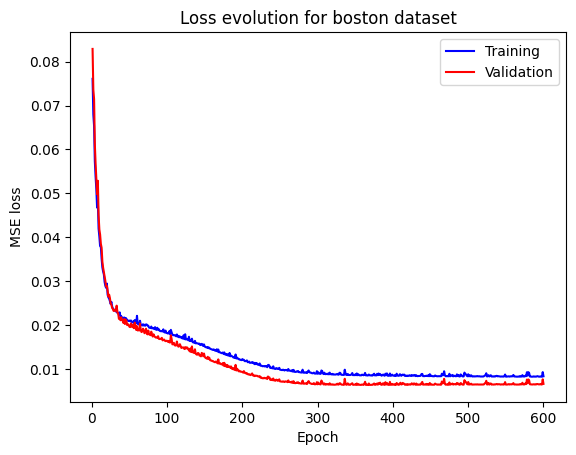

NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
boston & 4 & [13, 8, 6, 1] & 600 & 0.01 & 0.8 & linear & 100.0 & 0.168 \\
\hline
NEW
NEW
NEW


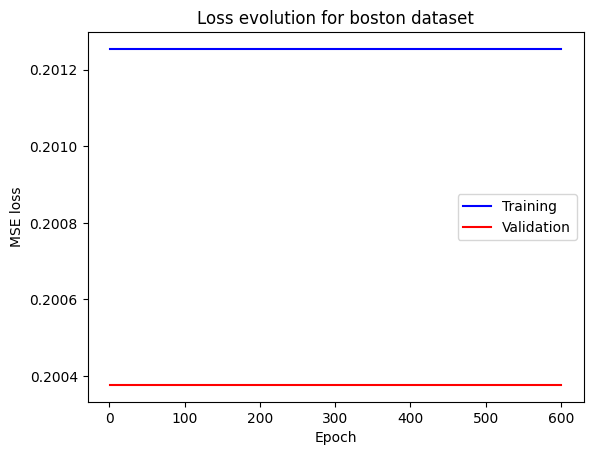

In [12]:
# execution with only relu with different learning rates
execute_parameters(test_parameters)

hi
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & lrelu & 2.3 & 0.000 \\
\hline
NEW
NEW


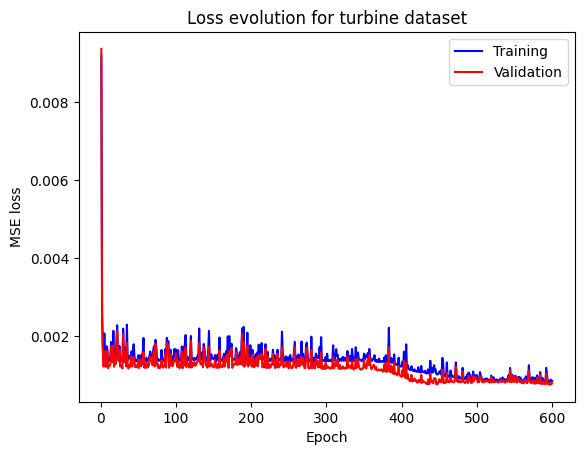

hi
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & lrelu & 2.7 & 0.000 \\
\hline
NEW
NEW


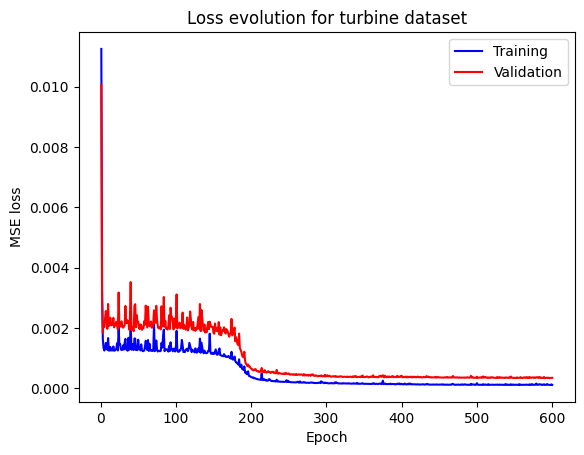

hi
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.2 & lrelu & 6.7 & 0.001 \\
\hline
NEW
NEW
NEW


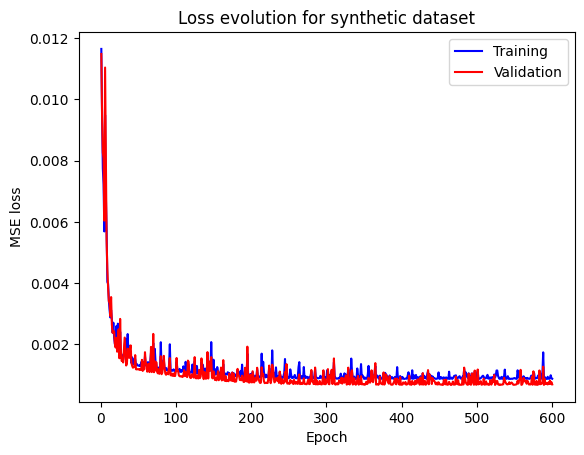

hi
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
synthetic & 2 & [9, 1] & 600 & 0.01 & 0.9 & lrelu & 6.6 & 0.001 \\
\hline
NEW


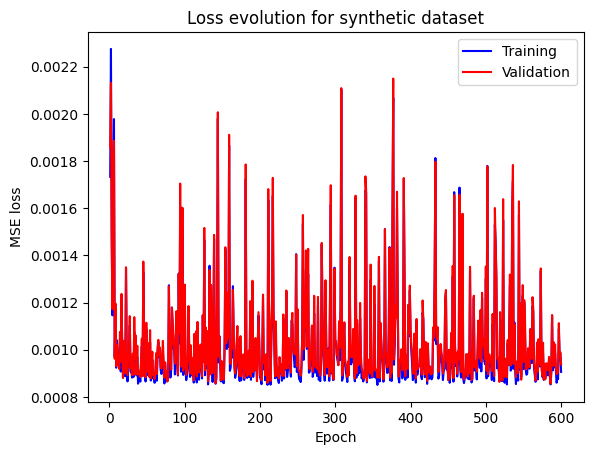

hi
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
boston & 4 & [13, 8, 6, 1] & 600 & 0.001 & 0.4 & lrelu & 15.9 & 0.007 \\
\hline
NEW
NEW
NEW


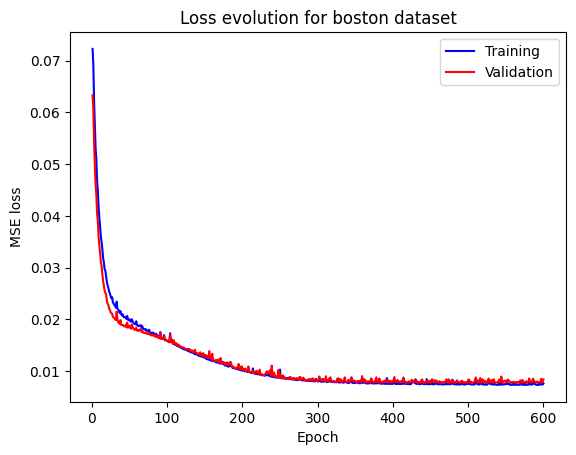

hi
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
NEW
boston & 4 & [13, 8, 6, 1] & 600 & 0.01 & 0.8 & lrelu & 15.1 & 0.005 \\
\hline
NEW
NEW
NEW


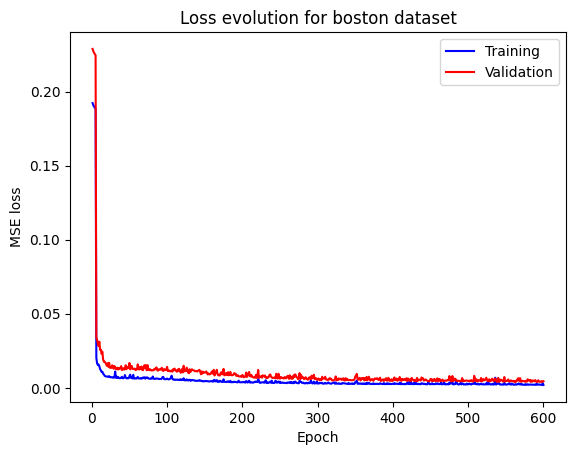

In [20]:
# execution with only relu with different learning rates
execute_parameters(test_parameters, activation_function=  'lrelu')

hi
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & sigmoid & 6.2 & 0.001 \\
\hline


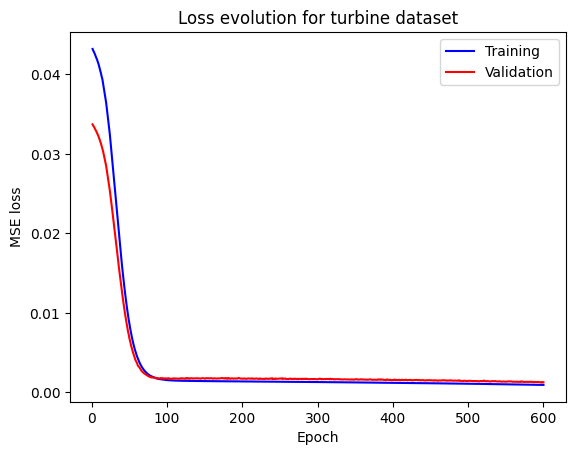

hi
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & sigmoid & 6.8 & 0.001 \\
\hline


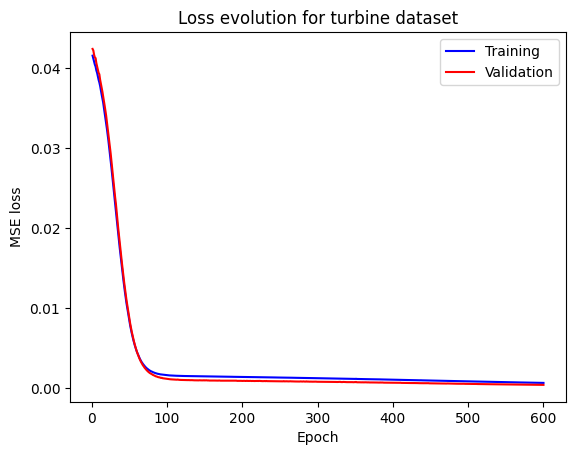

hi
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.2 & sigmoid & 7.3 & 0.001 \\
\hline


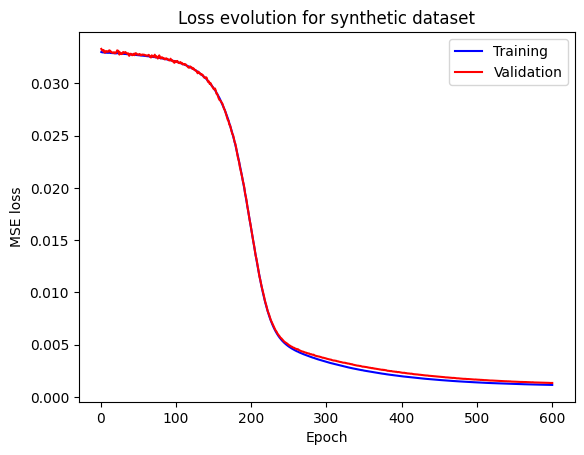

hi
synthetic & 2 & [9, 1] & 600 & 0.01 & 0.9 & sigmoid & 6.3 & 0.001 \\
\hline


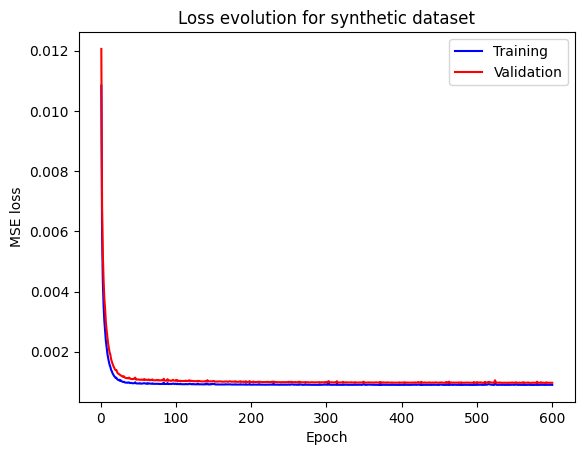

hi
boston & 4 & [13, 8, 6, 1] & 600 & 0.001 & 0.4 & sigmoid & 24.5 & 0.022 \\
\hline


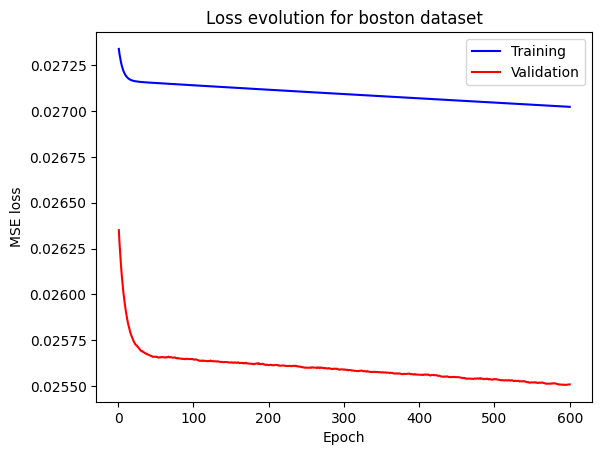

hi
boston & 4 & [13, 8, 6, 1] & 600 & 0.01 & 0.8 & sigmoid & 14.1 & 0.004 \\
\hline


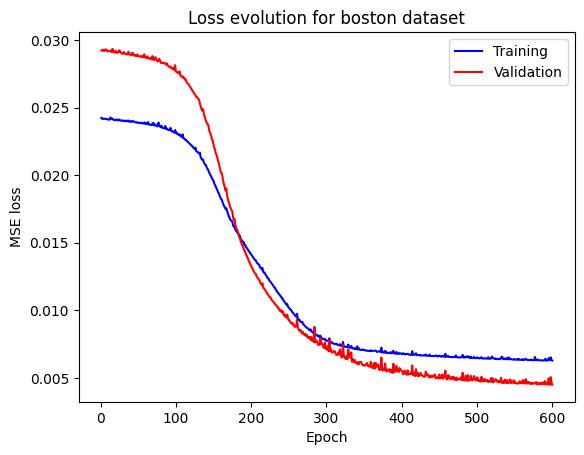

In [21]:
# execution with only relu with different learning rates
execute_parameters(test_parameters, activation_function=  'sigmoid')


hi
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & tanh & 2.0 & 0.000 \\
\hline


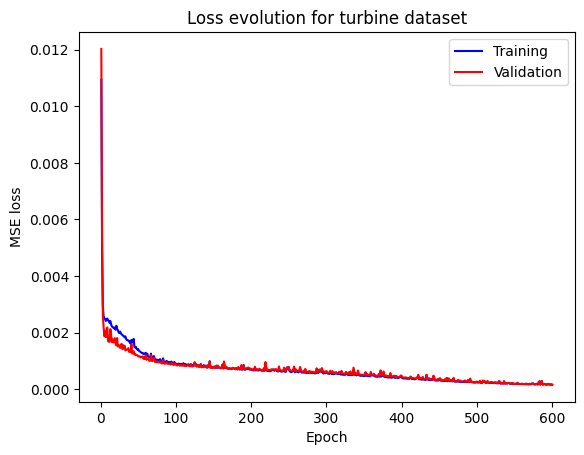

hi
turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & tanh & 1.8 & 0.000 \\
\hline


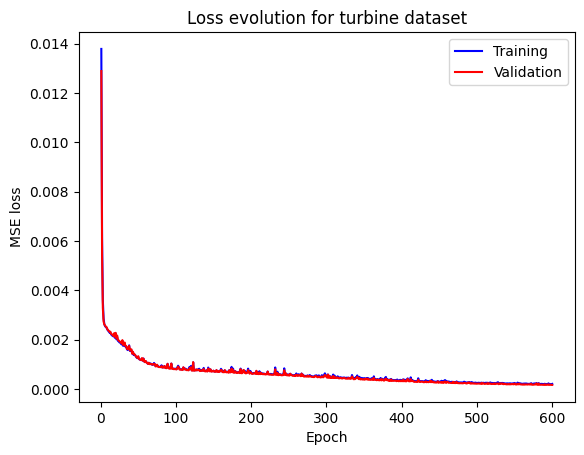

hi
synthetic & 4 & [9, 8, 6, 1] & 600 & 0.01 & 0.2 & tanh & 6.2 & 0.001 \\
\hline


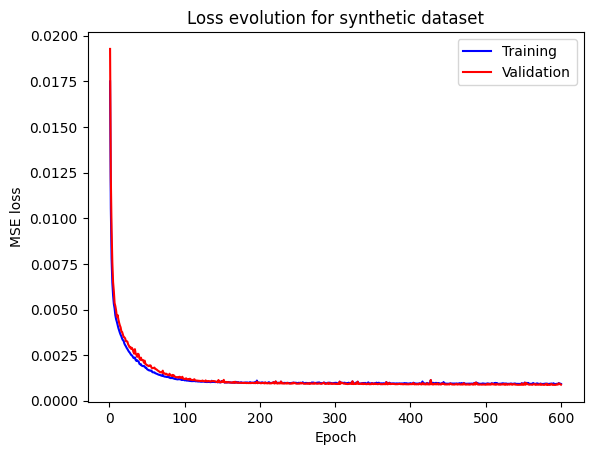

hi
synthetic & 2 & [9, 1] & 600 & 0.01 & 0.9 & tanh & 6.1 & 0.001 \\
\hline


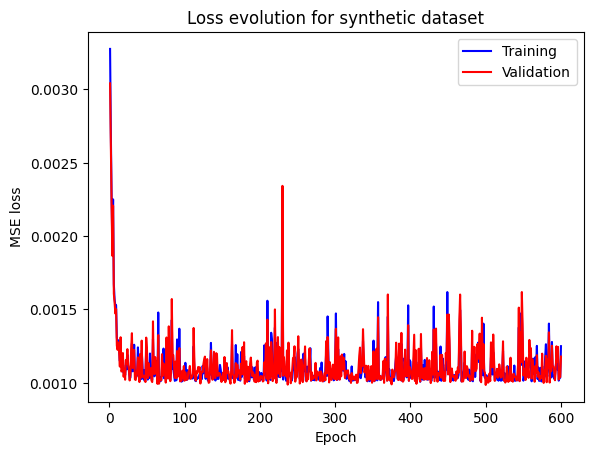

hi
boston & 4 & [13, 8, 6, 1] & 600 & 0.001 & 0.4 & tanh & 16.9 & 0.005 \\
\hline


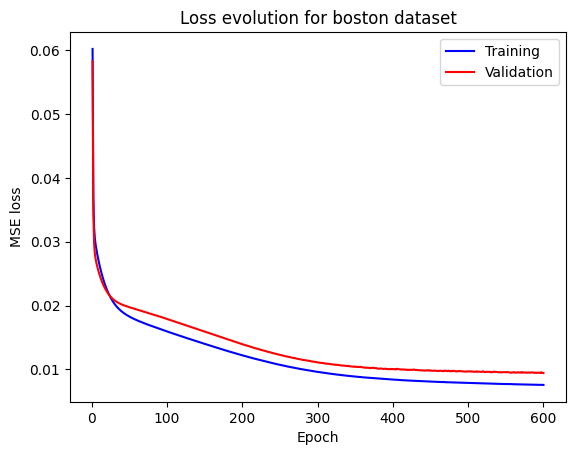

hi
boston & 4 & [13, 8, 6, 1] & 600 & 0.01 & 0.8 & tanh & 14.4 & 0.003 \\
\hline


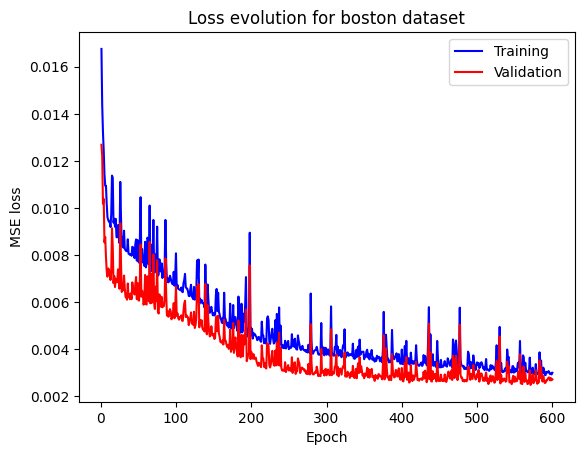

In [22]:
# execution with only relu with different learning rates
execute_parameters(test_parameters, activation_function=  'tanh')

#### Generating plots for 3.1

In [46]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

def run_and_plot_for_dataset(network_parameters, dataset, train_ratio, name_on_plots):
    network = MyNeuralNetwork_New.MyNeuralNetwork(*network_parameters)
    # Train on part of data and scatter predictions
    split_index = int(train_ratio * dataset.shape[0])
    

    network.fit(dataset[:split_index, :-1], dataset[:split_index, -1], batch_size=1)
    predictions = network.predict(dataset[split_index:, :-1])

    loss = network.loss_epochs()
    loss_train = loss[:, 0]
    loss_val = loss[:, 1]

    plt.plot(range(1, network_parameters[1] + 1), loss_train, color='blue')
    plt.plot(range(1, network_parameters[1] + 1), loss_val, color='red')
    plt.title(f"Loss evolution for {name_on_plots} dataset with Mape {calculate_mape(predicted=predictions, real=dataset[split_index:, -1])}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend(["Training", "Validation"])
    plt.show()

    

    return dataset[split_index:, -1], predictions

In [9]:
def scatter_for_network(real, predictions, name):
    plt.scatter(real, predictions)
    plt.xlabel("Real")
    plt.ylabel("Prediction")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(f"Predicted vs real values for {name} dataset")

### Turbine

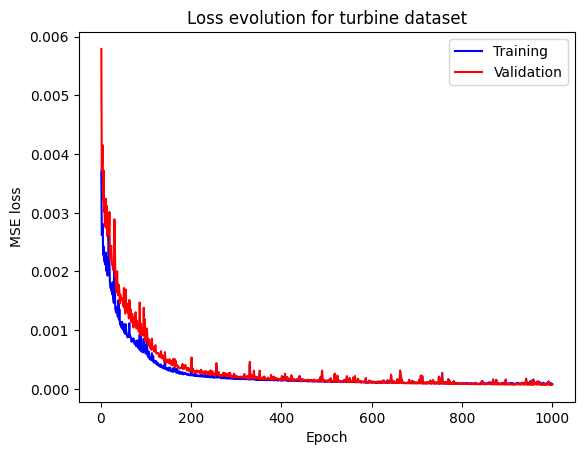

In [26]:
real, pred = run_and_plot_for_dataset([[4, 5, 1], 1000, 0.01, 0.9, "tanh", 0.2], turbine, 0.85, "turbine")


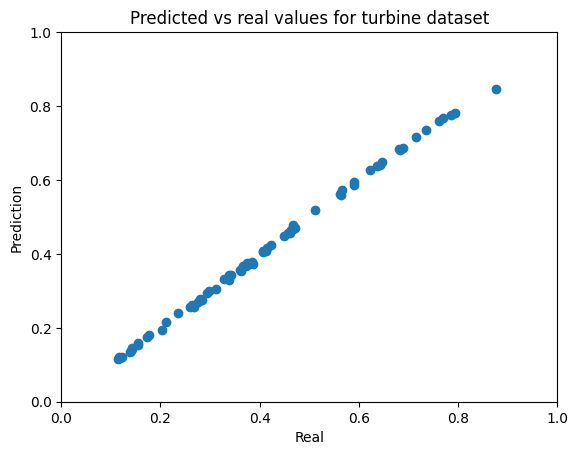

In [27]:
scatter_for_network(real, pred, "turbine")

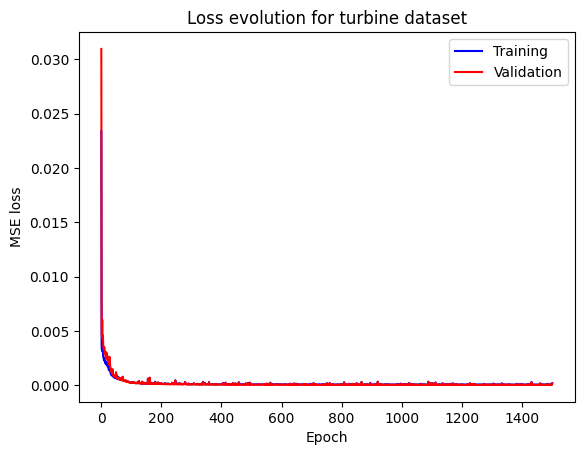

In [43]:
#turbine & 3 & [4, 5, 1] & 600 & 0.1 & 0.2 & relu & 100.0 & 0.178
#turbine & 6 & [4, 5, 8, 60, 6, 1] & 600 & 0.001 & 0.2 & tanh & 100.0 & 0.164
#turbine & 3 & [4, 5, 1] & 600 & 0.01 & 0.8 & tanh & 1.8 & 0.000
real, pred = run_and_plot_for_dataset([[4, 5, 8, 60, 6, 1], 1500, 0.01, 0.9, "tanh", 0.2], turbine, 0.85, "turbine")

68
68


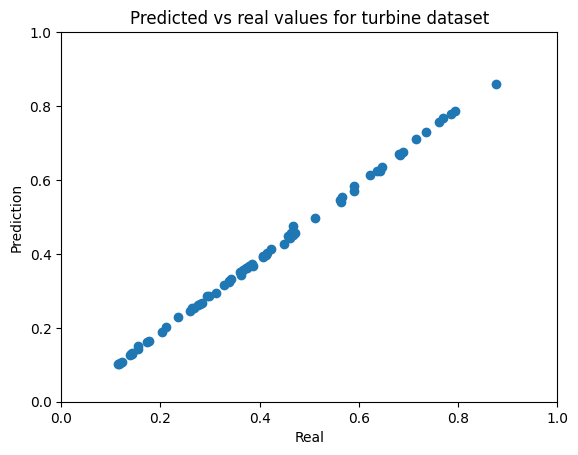

In [45]:
print(len(pred))
print(len(real))


scatter_for_network(real, pred, "turbine")

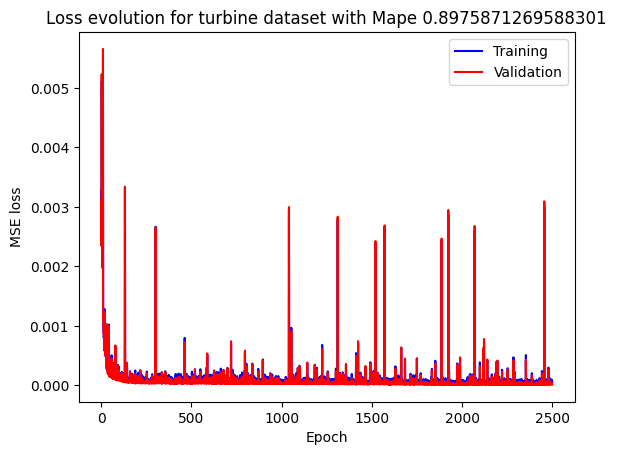

In [53]:
real, pred = run_and_plot_for_dataset([[4, 16, 8, 1], 2500, 0.3, 0.2, "tanh", 0.2], turbine, 0.85, "turbine")


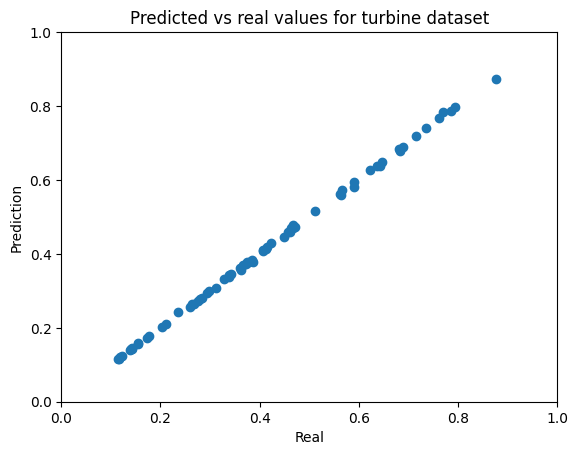

In [54]:
scatter_for_network(real, pred, "turbine")

### Synthetic

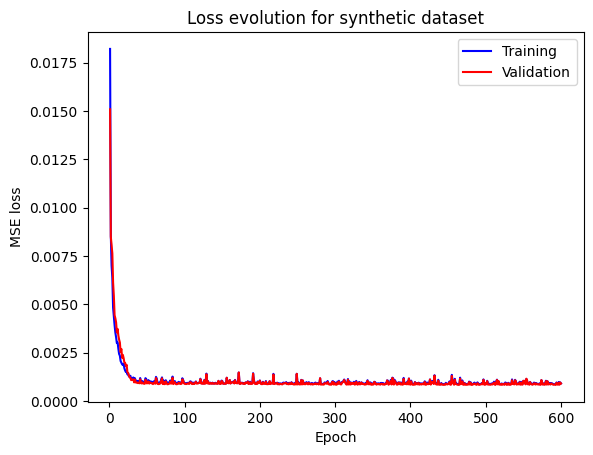

In [33]:
real, pred = run_and_plot_for_dataset([[9, 6, 10, 1], 1000, 0.01, 0.2, "relu", 0.1], synthetic, 0.8, "synthetic")

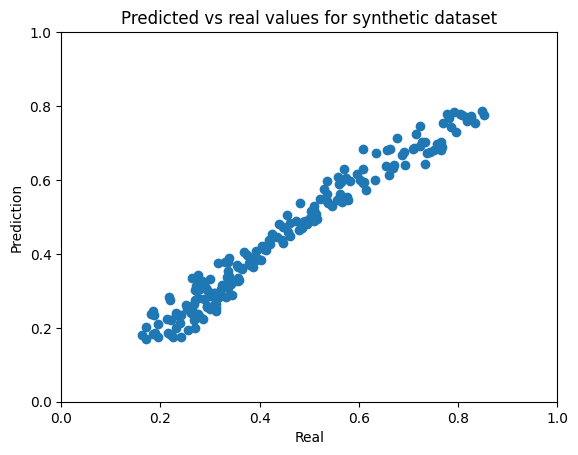

In [29]:
scatter_for_network(real, pred, "synthetic")

In [540]:
import importlib
importlib.reload(MyNeuralNetwork_New)

<module 'MyNeuralNetwork_New' from '/home/mrs/URV/NEC/HW1/MyNeuralNetwork_New.py'>

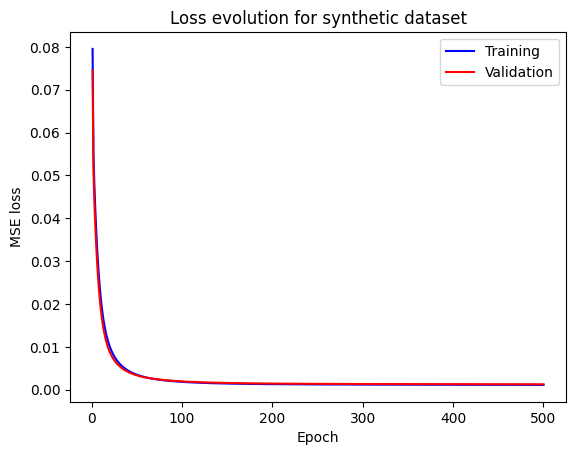

In [31]:
real, pred = run_and_plot_for_dataset([[9, 1], 500, 0.001, 0.2, "tanh", 0.2], synthetic, 0.8, "synthetic")

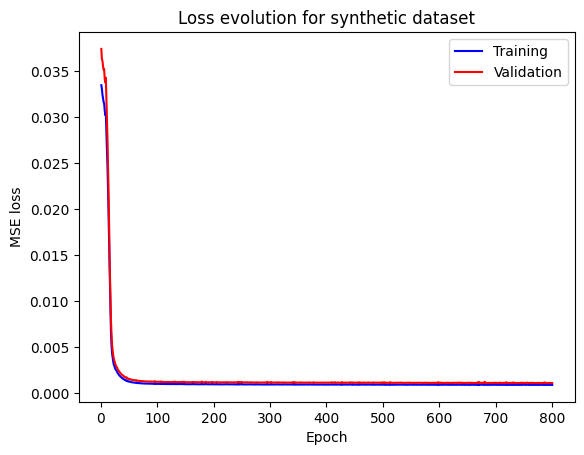

In [32]:
real, pred = run_and_plot_for_dataset([[9, 8, 6, 1], 800, 0.01, 0.9, "sigmoid", 0.2], synthetic, 0.8, "synthetic")

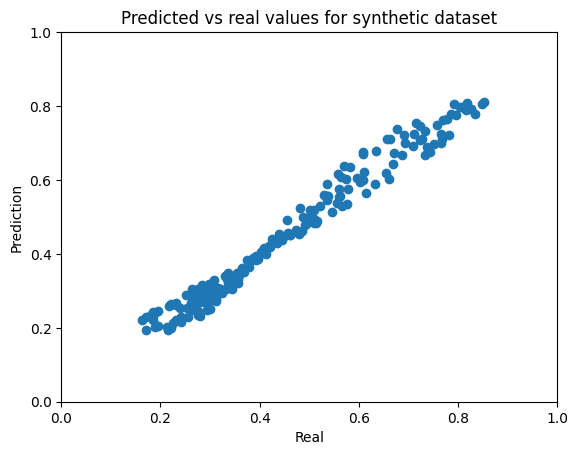

In [34]:
scatter_for_network(real, pred, "synthetic")

### Boston

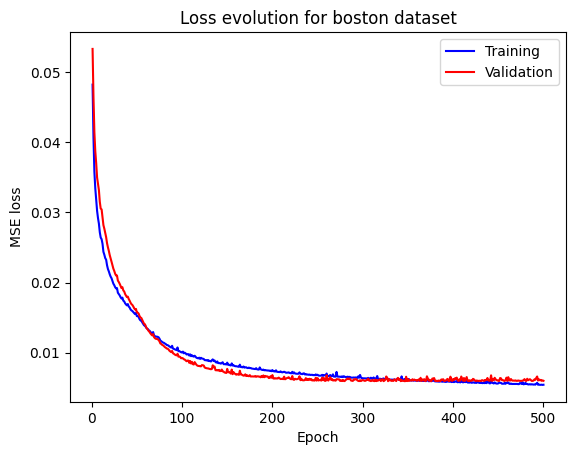

In [35]:
real, pred = run_and_plot_for_dataset([[13, 8, 6, 1], 500, 0.001, 0.7, "relu", 0.2], boston, 0.8, "boston")

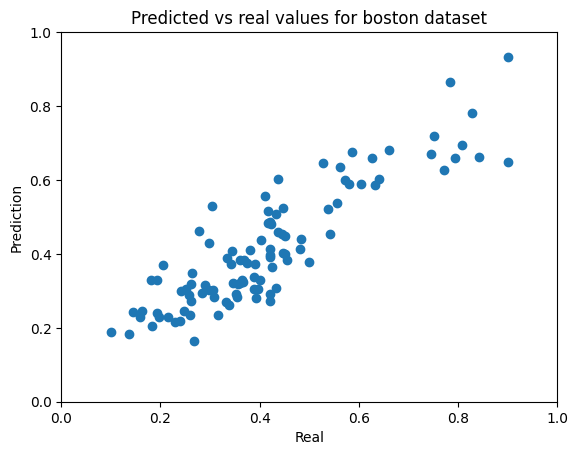

In [37]:
scatter_for_network(real, pred, "boston")

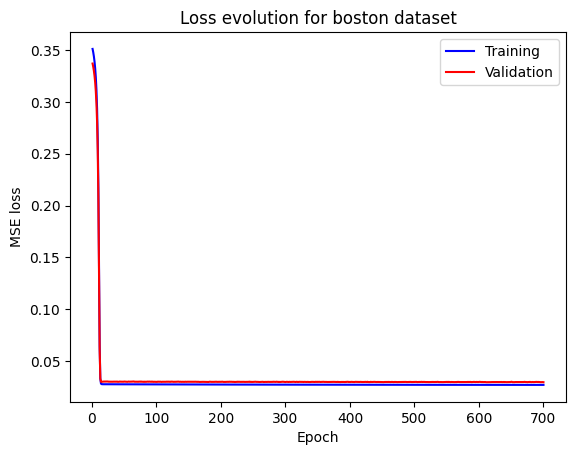

In [26]:
# this ia an example where not functions rightly 
#real, pred = run_and_plot_for_dataset([[13, 8, 6, 1], 70, 0.001, 0.9, "sigmoid", 0.2], boston, 0.8, "boston")

real, pred = run_and_plot_for_dataset([[13, 4, 4, 1], 700, 0.001, 0.2, "tanh", 0.2], boston, 0.8, "boston")

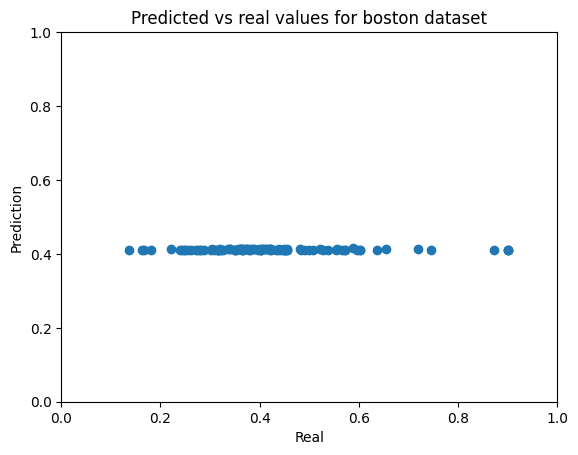

In [28]:
scatter_for_network(real, pred, "boston")

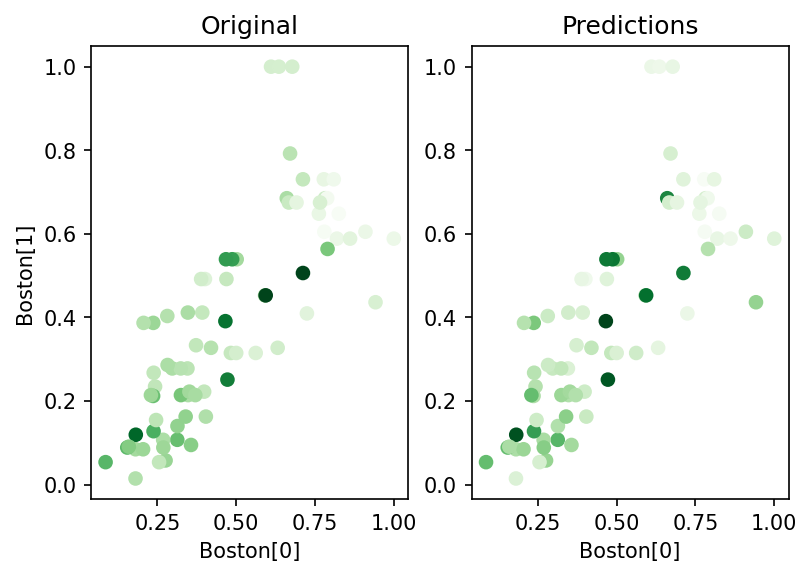

In [264]:
# A nice plot with colors representing predictions and needed value
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

n_epochs = 100
data = boston
network = MyNeuralNetwork_New.MyNeuralNetwork([13, 8, 7, 1], n_epochs, 0.01, 0.9, "tanh", 0.2)
# Train on part of data and scatter predictions
split_index = int(0.85 * data.shape[0])
network.fit(data[:split_index, :-1], data[:split_index, -1], batch_size=10)
predictions = network.predict(data[split_index:, :-1])

plt.subplot(1, 2, 1)
plt.scatter(data[split_index:, 0], data[split_index:, 4], c=data[split_index:, -1], marker='o', cmap='Greens')
plt.xlabel("Boston[0]")
plt.ylabel("Boston[1]")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.xlabel("Boston[0]")
plt.title("Predictions")
plt.scatter(data[split_index:, 0], data[split_index:, 4], c=predictions, marker='o', cmap='Greens')



# Part 3.2

In this section we will train and test a neural network from pytourch for each dataset and fit and predict with MLR from sklearn.

### Turbine

In [19]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[4, 8, 6, 1], 'tanh'], *args), turbine, num_runs=3)

C:\Users\savas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Model MSE on test: 3.55716583726462e-05
Model MSE on test: 0.00022980428184382617
Model MSE on test: 4.987067950423807e-05


(1.6005704179406166, 3.557166e-05)

In [20]:
measure_model_error_multiple_times(run_linear_regression, turbine, num_runs=10)

Model MSE on test: 0.001162990229204297
Model MSE on test: 0.0015790695324540138
Model MSE on test: 0.00108962575905025
Model MSE on test: 0.001041002687998116
Model MSE on test: 0.0009323626873083413
Model MSE on test: 0.0007629471947439015
Model MSE on test: 0.0011831875890493393
Model MSE on test: 0.00104023318272084
Model MSE on test: 0.0009721506503410637
Model MSE on test: 0.0013708140468224883


(6.838356703519821, 0.0007629472)

### Synthetic

In [23]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[9, 8, 6, 1], 'tanh'], *args), synthetic, num_runs=3)

Model MSE on test: 0.0007701332215219736
Model MSE on test: 0.0009415783570148051
Model MSE on test: 0.0009366665035486221


(5.55947870016098, 0.0007701332)

In [24]:
measure_model_error_multiple_times(run_linear_regression, boston, num_runs=10)

Model MSE on test: 0.003983357455581427
Model MSE on test: 0.006916094105690718
Model MSE on test: 0.007077500224113464
Model MSE on test: 0.010682960972189903
Model MSE on test: 0.011704984121024609
Model MSE on test: 0.00849582813680172
Model MSE on test: 0.0103526059538126
Model MSE on test: 0.00572854932397604
Model MSE on test: 0.009917939081788063
Model MSE on test: 0.006056645885109901


(13.50669264793396, 0.0039833575)

### Boston

In [53]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[13, 8, 6, 1], 'linear'], *args), boston, num_runs=3)

Model MSE on test: 0.006103582214564085
Model MSE on test: 0.006622966844588518
Model MSE on test: 0.006216857116669416


(18.832014501094818, 0.006103582)

### I was playing much with parameters here and rerunning stuff for tables generation, so it's a mess here now. I was replacing function inputs for different datasets

In [15]:
measure_model_error_multiple_times(lambda *args: run_my_neural_network([[4, 12, 10, 13, 10, 9, 1], 1000, 0.01, 0.9, 'tanh', 0.01], *args), turbine, num_runs=10)


Model MSE on test: 0.07268177282180045
Model MSE on test: 0.04351102867804812
Model MSE on test: 0.1962278656726431
Model MSE on test: 0.04840728019770292
Model MSE on test: 0.07839071062951211
Model MSE on test: 0.11146070211810744
Model MSE on test: 0.0553912980339489
Model MSE on test: 0.04647760425515442
Model MSE on test: 0.04004328446910168
Model MSE on test: 0.043307133841672604


(56.764477186693895, 0.04004328446910168)

In [673]:
measure_model_error_multiple_times(run_linear_regression, boston, num_runs=10)

Model MSE on test: 0.010275826789438725
Model MSE on test: 0.009059252217411995
Model MSE on test: 0.010363048873841763
Model MSE on test: 0.006425630301237106
Model MSE on test: 0.009259392507374287
Model MSE on test: 0.008090280927717686
Model MSE on test: 0.0056296358816325665
Model MSE on test: 0.008469571359455585
Model MSE on test: 0.008154272101819515
Model MSE on test: 0.008353237062692642


(18.34287941455841, 0.005629636)